# Outlier detection models on Generated datasets

## 1. Generated datasets

### a. sklearn datasets

In [2]:
from sklearn.datasets import make_s_curve, make_moons, make_blobs, make_swiss_roll
import numpy as np

n_samples = 500
outlier_percentage = 0.15

n_outliers = int(n_samples * outlier_percentage)
n_inliers = n_samples - n_outliers

rng = np.random.RandomState(42)

def get_2d_dataset():
    blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
    dataset = [
        # single blob
        make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
                **blobs_params)[0],
        # 2 blobs of similar density
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
                **blobs_params)[0],
        # 2 blobs of different density
        make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
                **blobs_params)[0],
        # 2 ellipses of similar density
        np.dot(make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
                **blobs_params)[0], [[1, -0.6], [-0.2, 1]]),
        # 2 ellipses of different density
        np.dot(make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
                **blobs_params)[0], [[1, -0.6], [-0.2, 1]]),
        # s
        make_s_curve(n_samples=n_inliers, noise=0.2)[0][:, (0,2)],
        # swiss roll
        np.dot(make_swiss_roll(n_samples=n_inliers, noise=0.7)[0][:, (0,2)], 0.3),
        # 2D crescents
        4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
            np.array([0.5, 0.25])),
        # uniform
        #14. * (rng.rand(n_samples, 2) - 0.5)
    ]

    outliers = rng.uniform(low=-6, high=6, size=(n_outliers, 2))
    return outliers, dataset

def get_md_dataset():
    blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=10)
    dataset = [
        make_blobs(
            centers=[np.zeros(10), np.zeros(10)],
            cluster_std=0.5,
            **blobs_params)[0],
        make_blobs(
            centers=[2*np.ones(10), (-2)*np.ones(10)],
            cluster_std=[0.5, 0.5],
            **blobs_params)[0],
        make_blobs(
            centers=[2*np.ones(10), (-2)*np.ones(10)],
            cluster_std=[1.5, .3],
            **blobs_params)[0],
        # 14. * (np.random.RandomState(42).rand(n_samples, 10) - 0.5)
    ]

    outliers = rng.uniform(low=-6, high=6, size=(n_outliers, 10))
    return outliers, dataset

### b. Plot & PCA

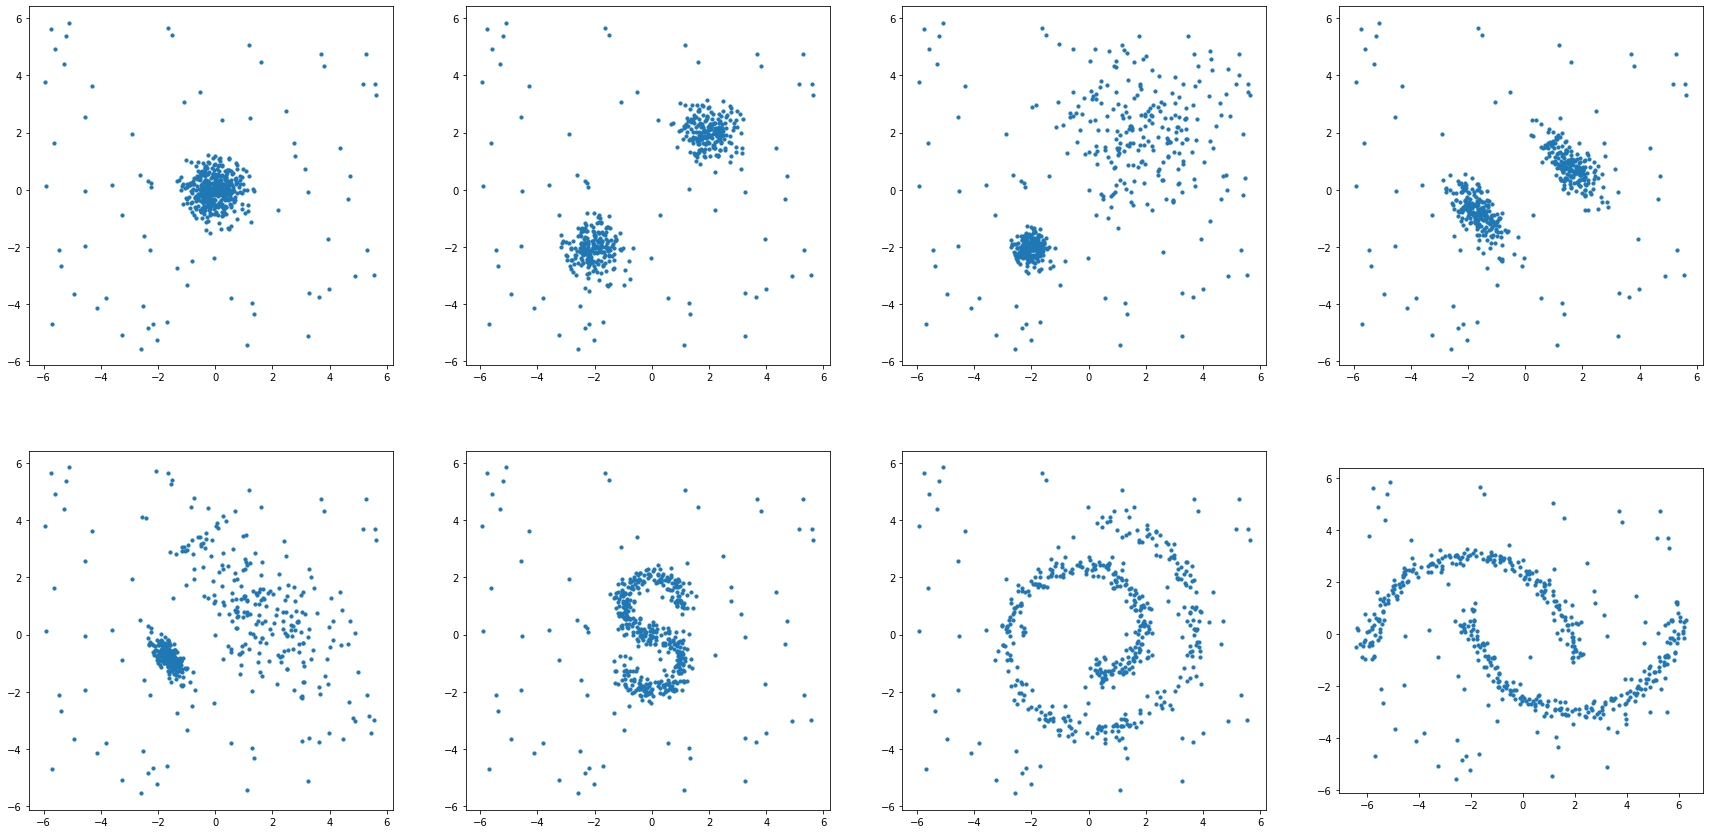

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 30))

outliers, ds = get_2d_dataset()

for dataset_i, inliers in enumerate(ds):
    X = np.concatenate([inliers, outliers], axis=0)

    if (dataset_i < 4):
        ax = fig.add_subplot(2, 4, dataset_i+1)
    elif (dataset_i < 8):
        ax = fig.add_subplot(1, 4, dataset_i+1-4)

    ax.set_aspect('equal')
    ax.scatter(X[:, 0], X[:, 1], s=10)

plt.show()

## 2. OD Models

In [4]:
# models
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.ocsvm import OCSVM
from pyod.models.loda import LODA
from pyod.models.iforest import IForest
#from datapg.AD.PCAAD import PCAAD

lof = LOF(contamination=outlier_percentage,n_neighbors=35, leaf_size=40, algorithm='auto', metric='minkowski', metric_params=None)
knn = KNN(contamination=outlier_percentage, n_neighbors=35, method='largest', leaf_size=40, radius=0.1, metric='minkowski', metric_params=None)
abod = ABOD(contamination=outlier_percentage, n_neighbors=35, method='fast')
ocsvm = OCSVM(contamination=outlier_percentage, kernel="rbf", gamma='auto')
loda = LODA(contamination=outlier_percentage, n_bins=20, n_random_cuts=400)
iforest = IForest(contamination=outlier_percentage, n_estimators=400, max_samples='auto')
# pcaad = PCAAD(contamination=0.05),

xx, yy = np.meshgrid(np.linspace(-7, 7, 75),
                     np.linspace(-7, 7, 75))

colors = np.array(['#67ae98', '#ff7f00'])

# demo anomaly detection on 2d dataset
def demo_anomalies_2d_data(detector, contour=True):
    fig = plt.figure(figsize=(30, 30))

    outliers, ds = get_2d_dataset()

    for dataset_i, inliers in enumerate(ds):
        X = np.concatenate([inliers, outliers], axis=0)

        if (dataset_i < 4):
            ax = fig.add_subplot(2, 4, dataset_i+1)
        elif (dataset_i < 8):
            ax = fig.add_subplot(1, 4, dataset_i+1-4)
        
        ax.set_aspect('equal')

        detector.fit(X)
        labels = detector.predict(X)

        if (contour):
            plot_space = np.c_[xx.ravel(), yy.ravel()]
            Z = detector.predict(plot_space)
            Z_contours = Z.reshape(xx.shape)
            ax.contour(xx, yy, Z_contours, levels=[0.5], linewidths=2, colors='black')

            Z = -1.0 * detector.decision_function(plot_space)
            Z_contours = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z_contours, levels=np.linspace(Z_contours.min(), Z_contours.max(), 10), cmap=plt.cm.Blues_r)

        ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

    plt.show()

### a. Local Outlier Factor

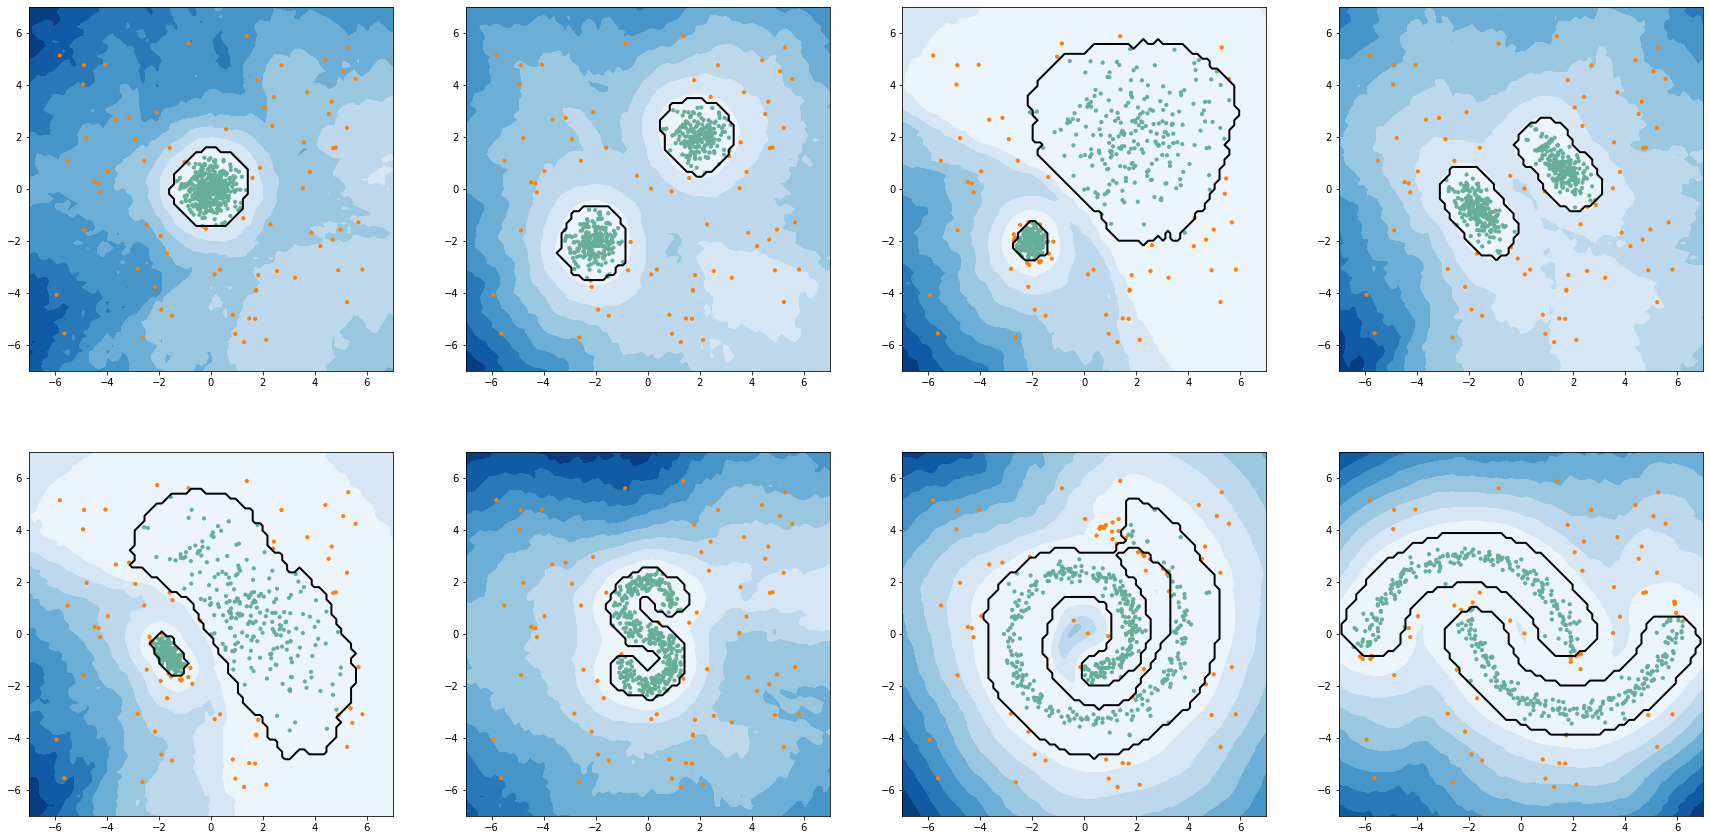

In [5]:
demo_anomalies_2d_data(lof)

### b. k-Nearest Neighbour (Fast Outlier Detector)

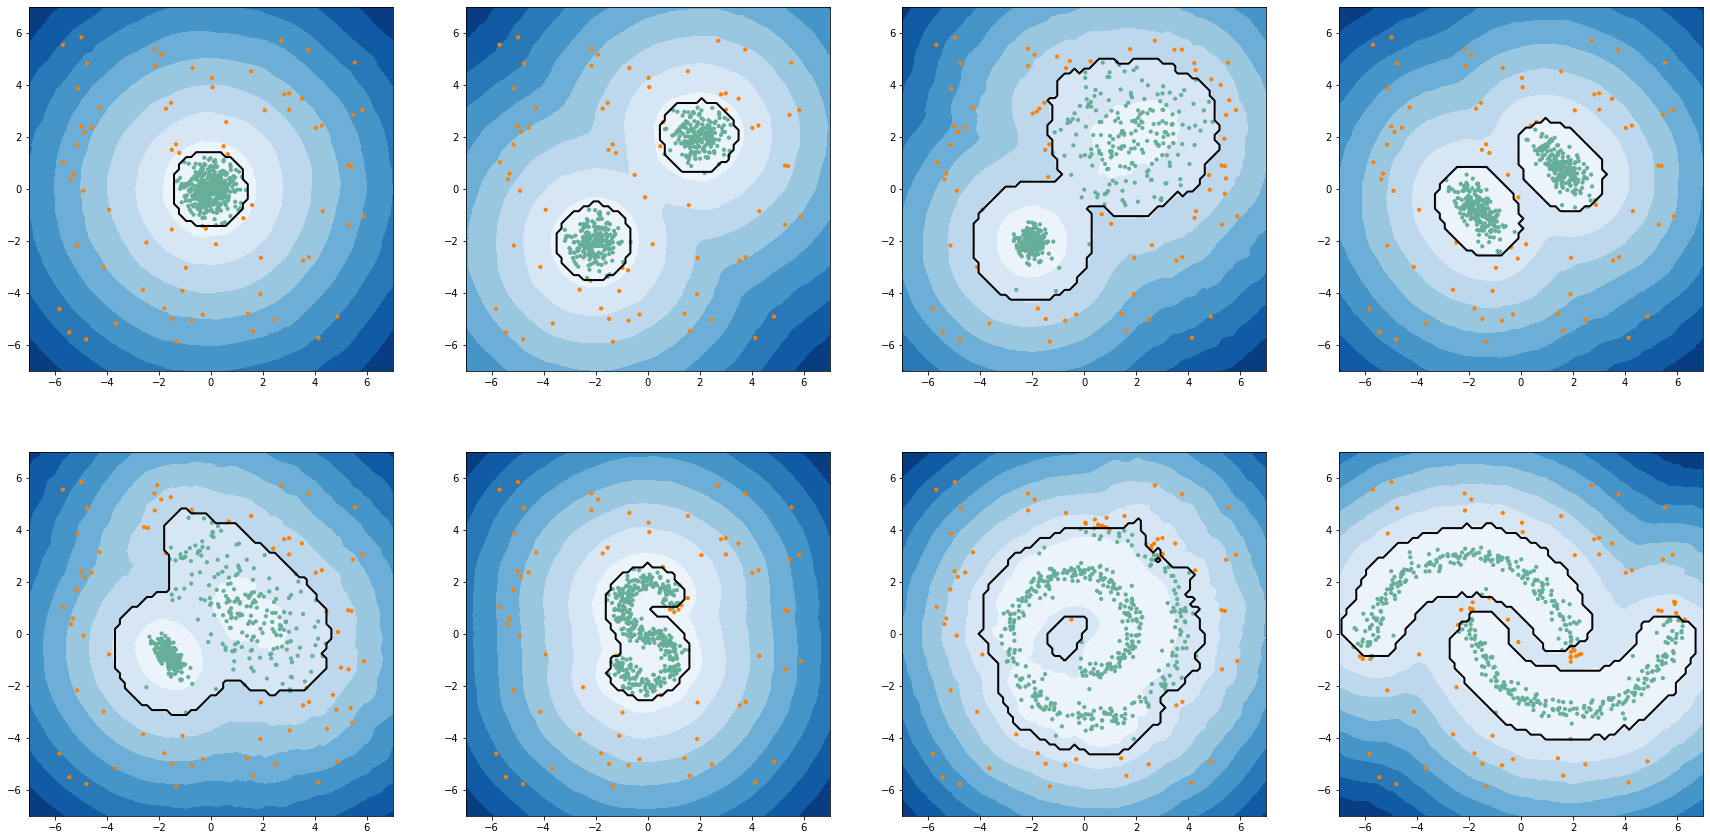

In [6]:
demo_anomalies_2d_data(knn)

### c. Angle-based Outlier Detector

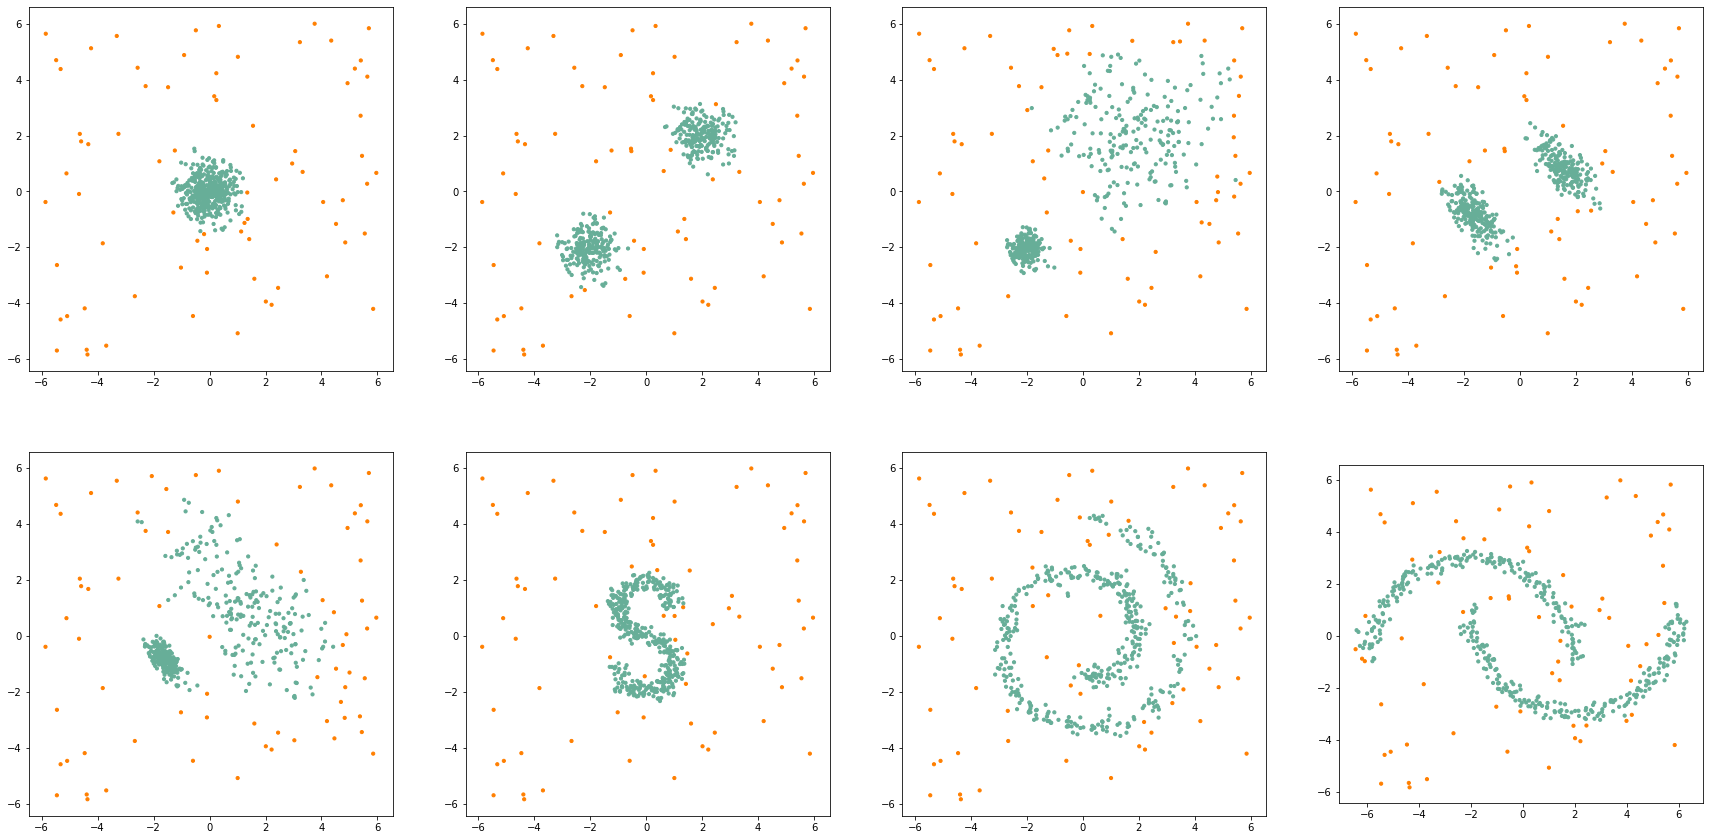

In [7]:
demo_anomalies_2d_data(abod, contour=False)

### d. One-class Support Vector Machine

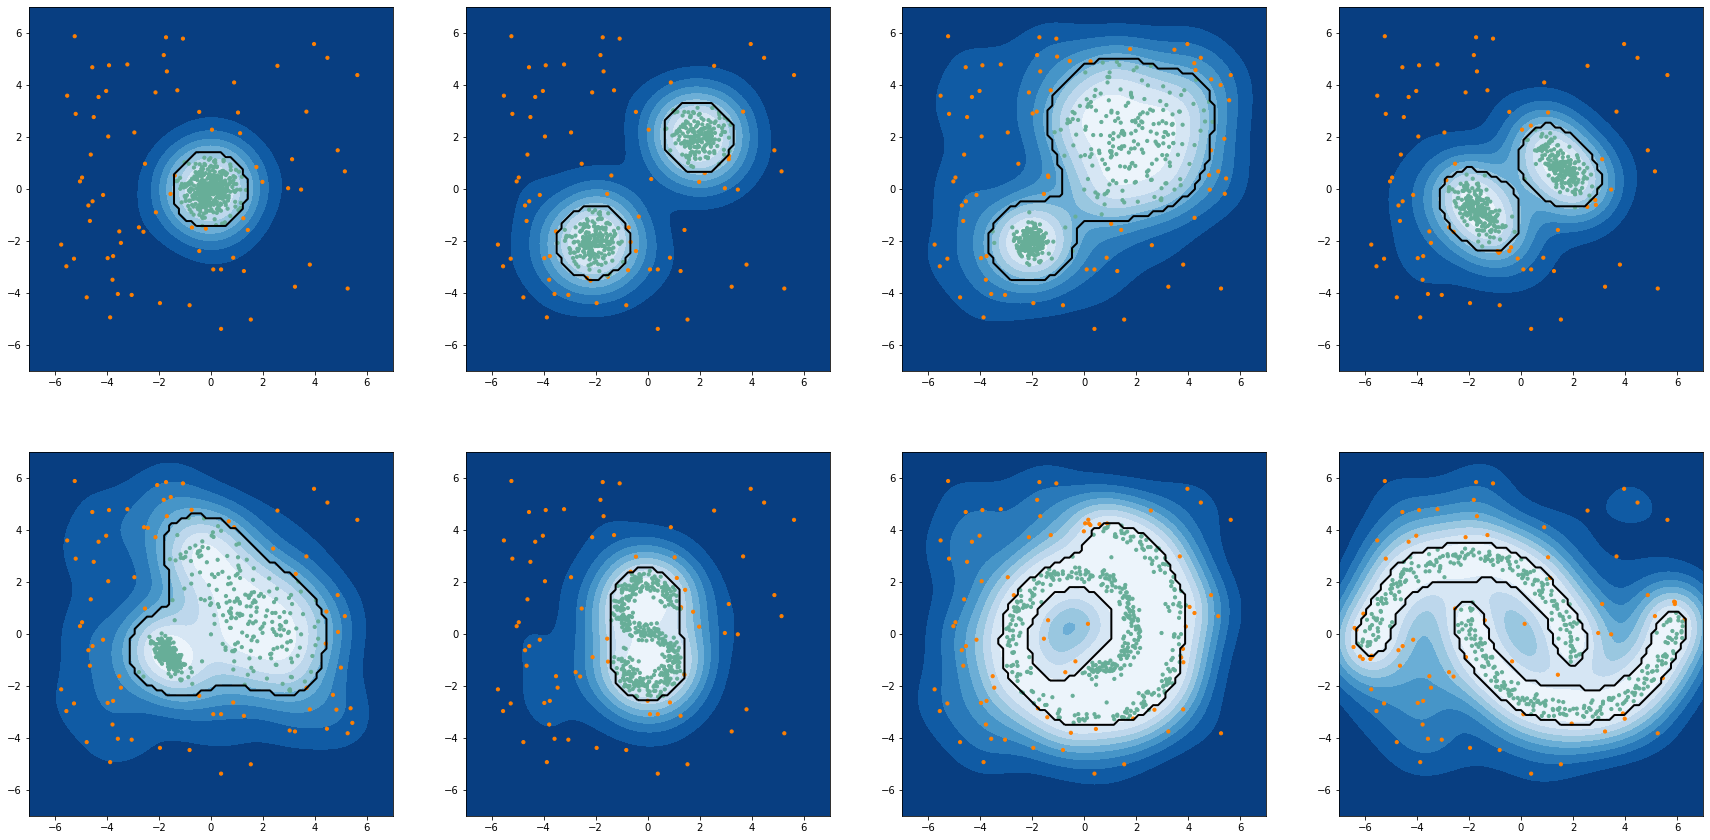

In [8]:
demo_anomalies_2d_data(ocsvm)

### e. Lightweight Online Detector

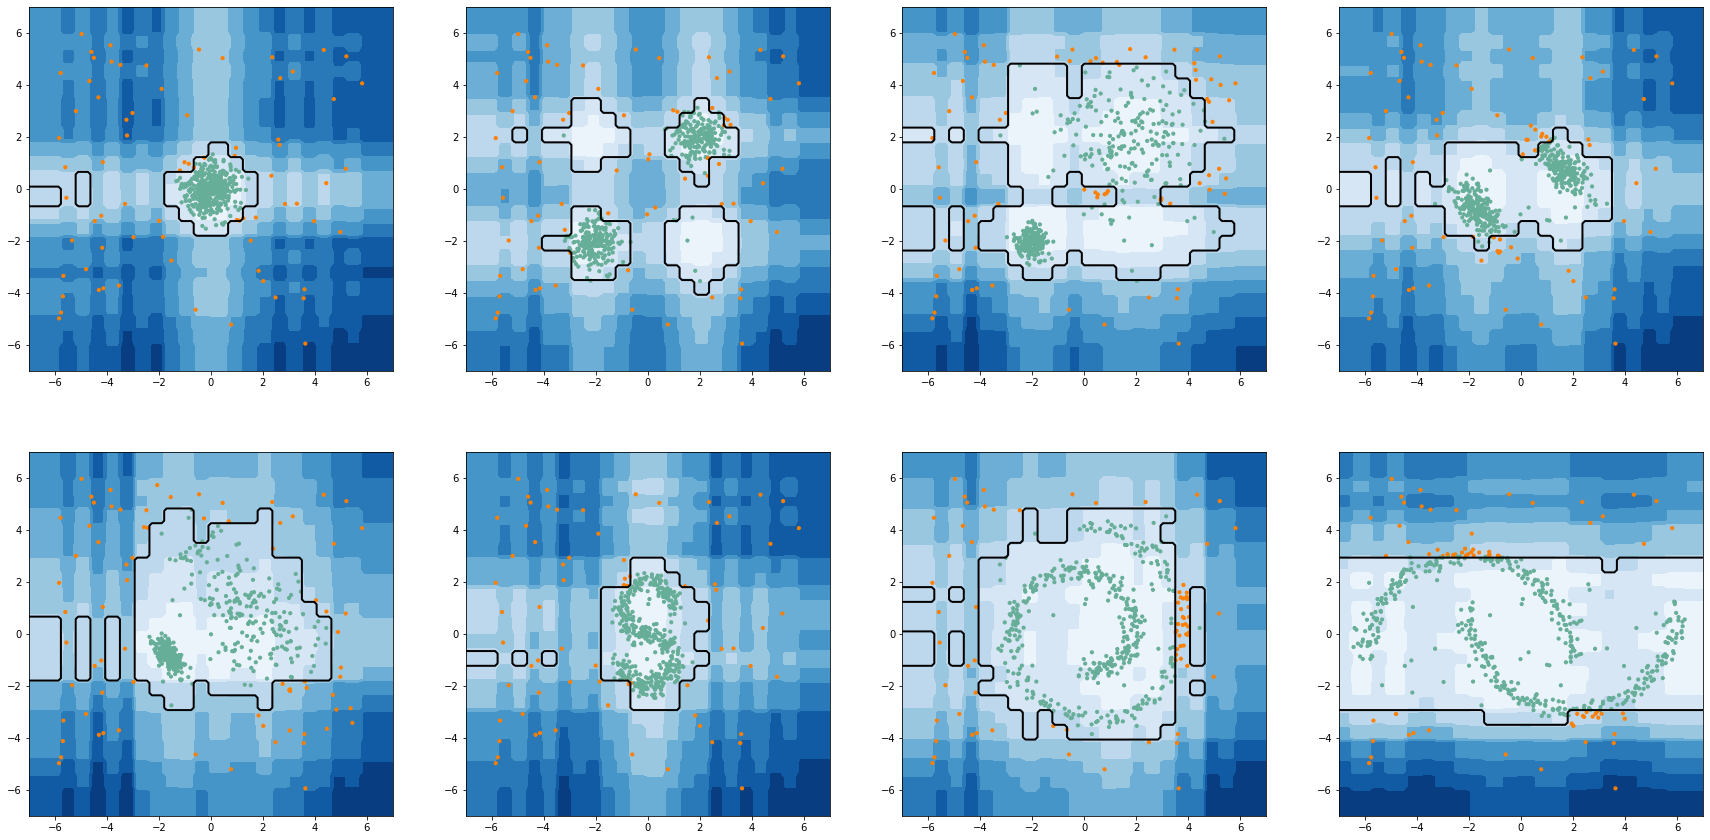

In [9]:
demo_anomalies_2d_data(loda)

### f. Isolation Forest

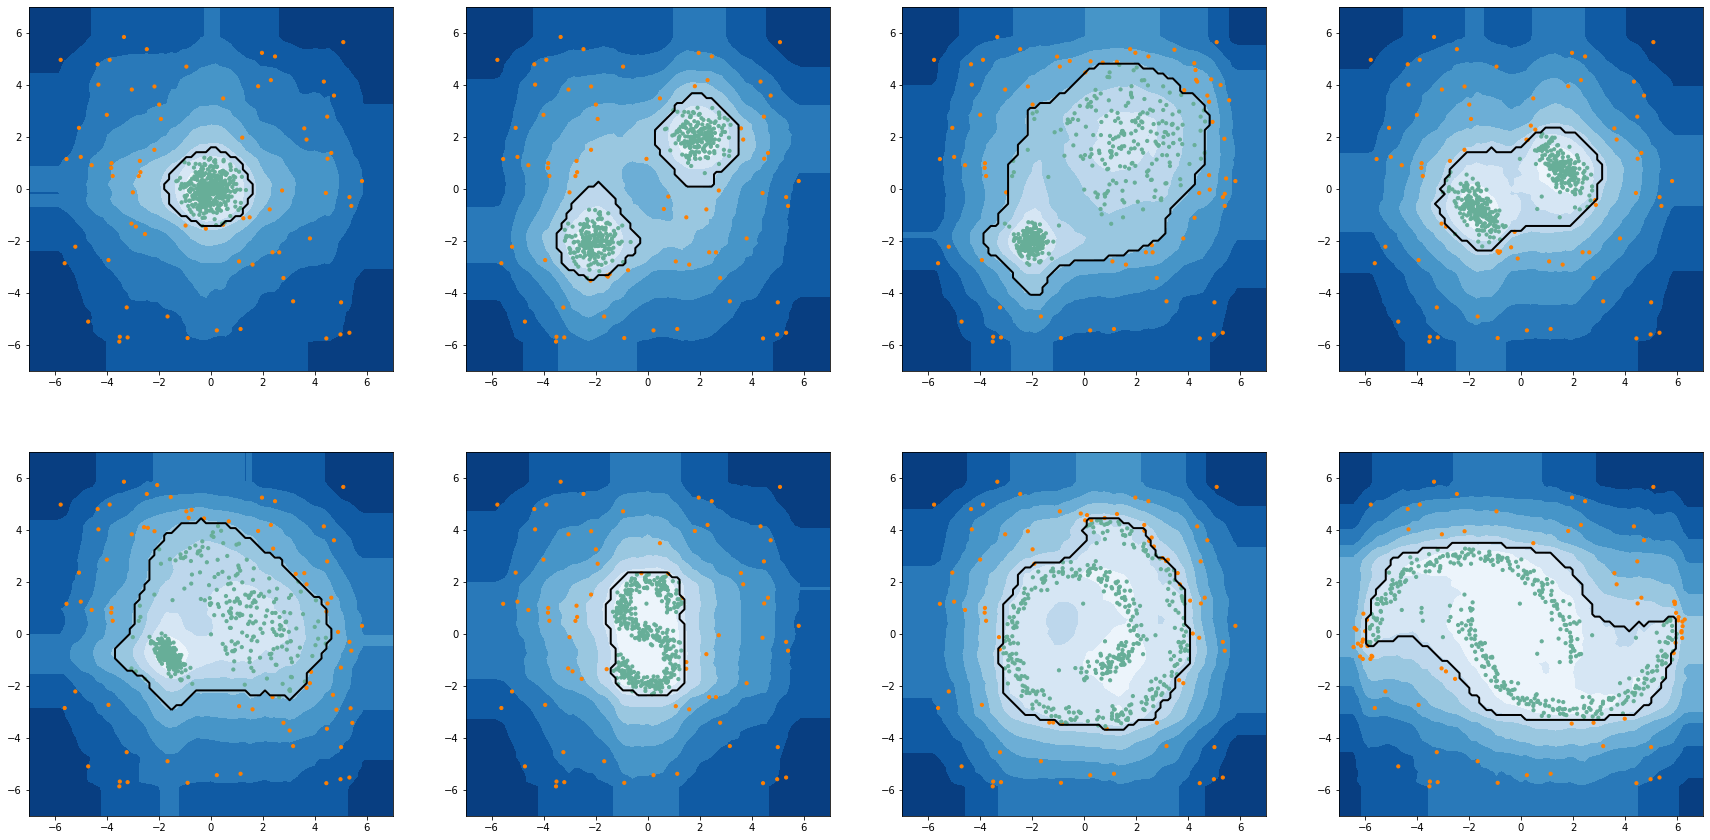

In [10]:
demo_anomalies_2d_data(iforest)

## 3. Statistics models for OD

In [11]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neighbors import KernelDensity

gmm = GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=200, n_components=3)
bgmm = BayesianGaussianMixture(covariance_type='full', init_params='random', weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=1e2, max_iter=400, n_components=7, n_init=7)
kde = KernelDensity(algorithm='auto', bandwidth=0.8, kernel='gaussian', leaf_size=35, metric='minkowski')

def demo_probability_2d_data(model):
    fig = plt.figure(figsize=(30, 30))
    outliers, ds = get_2d_dataset()

    for dataset_i, inliers in enumerate(ds):
        X = np.concatenate([inliers, outliers], axis=0)
        
        if (dataset_i < 4):
            ax = fig.add_subplot(2, 4, dataset_i+1)
        elif (dataset_i < 8):
            ax = fig.add_subplot(1, 4, dataset_i+1-4)

        ax.set_aspect('equal')

        model.fit(X)

        scores = model.score_samples(X)
        threshold = np.quantile(scores, 0.15) # 15% outliers
        labels = np.zeros(X.shape[0], dtype=int)
        labels[np.where(scores < threshold)] = 1

        plot_space = np.c_[xx.ravel(), yy.ravel()]
        Z = model.score_samples(plot_space)
        Z_labels = np.zeros(plot_space.shape[0], dtype=int)
        Z_labels[np.where(Z < threshold)] = 1
        Z_contours = Z_labels.reshape(xx.shape)
        ax.contour(xx, yy, Z_contours, levels=[0.5], linewidths=2, colors='black')

        Z = model.score_samples(plot_space)
        Z_contours = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z_contours, levels=np.linspace(Z_contours.min(), Z_contours.max(), 10), cmap=plt.cm.Blues_r)
        ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[labels])

    plt.show()

### a. Gaussian Mixture Model

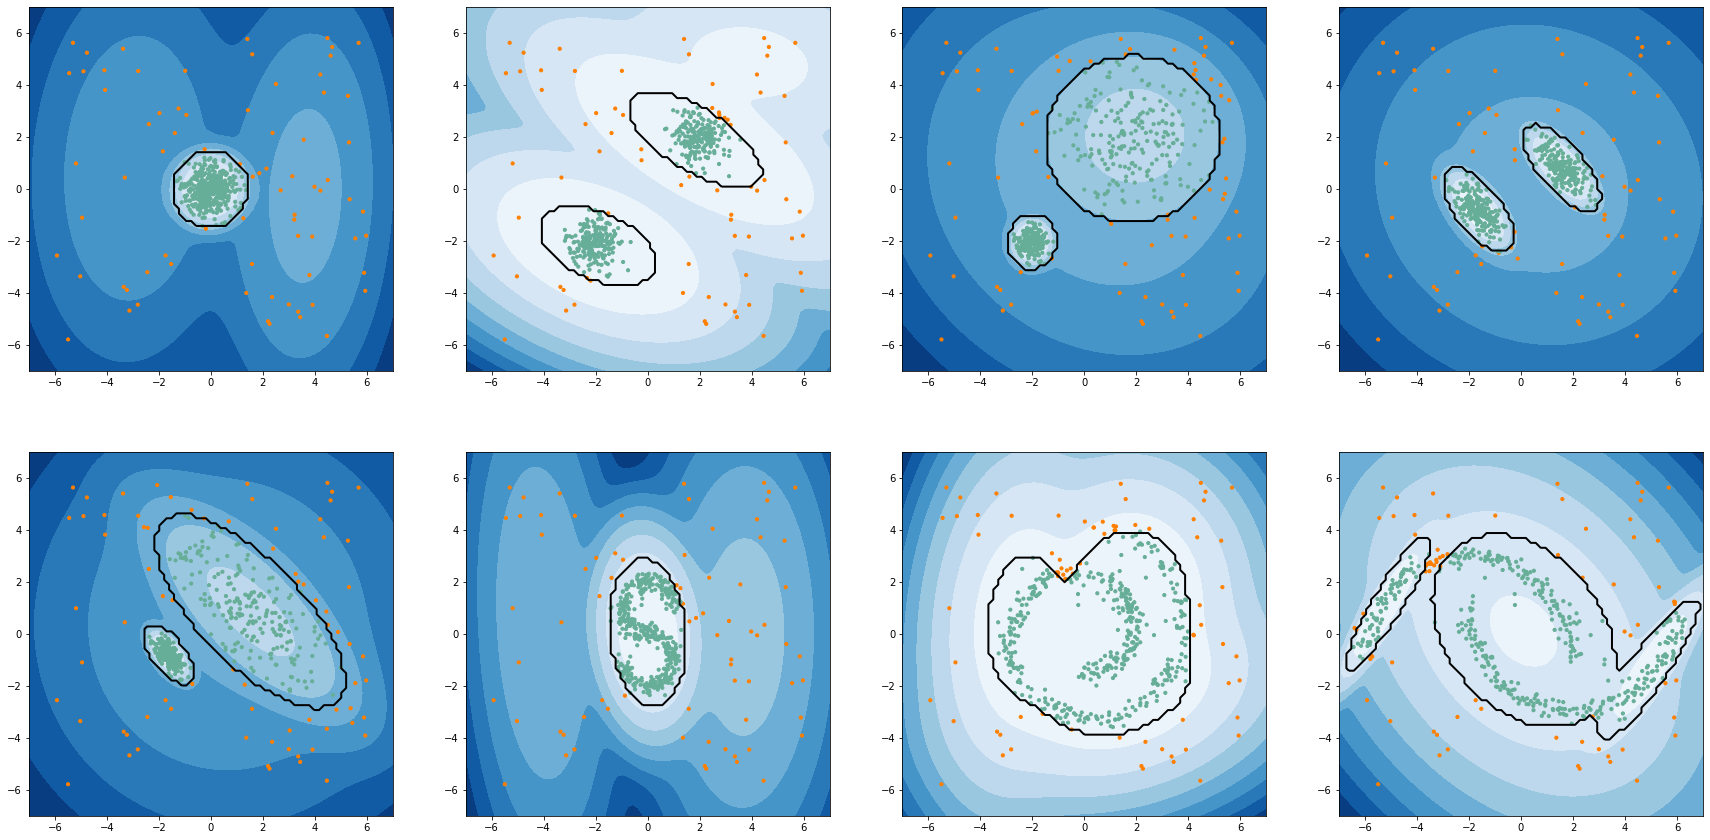

In [12]:
demo_probability_2d_data(gmm)

### b. Bayesian Variational Inference Gaussian Mixture

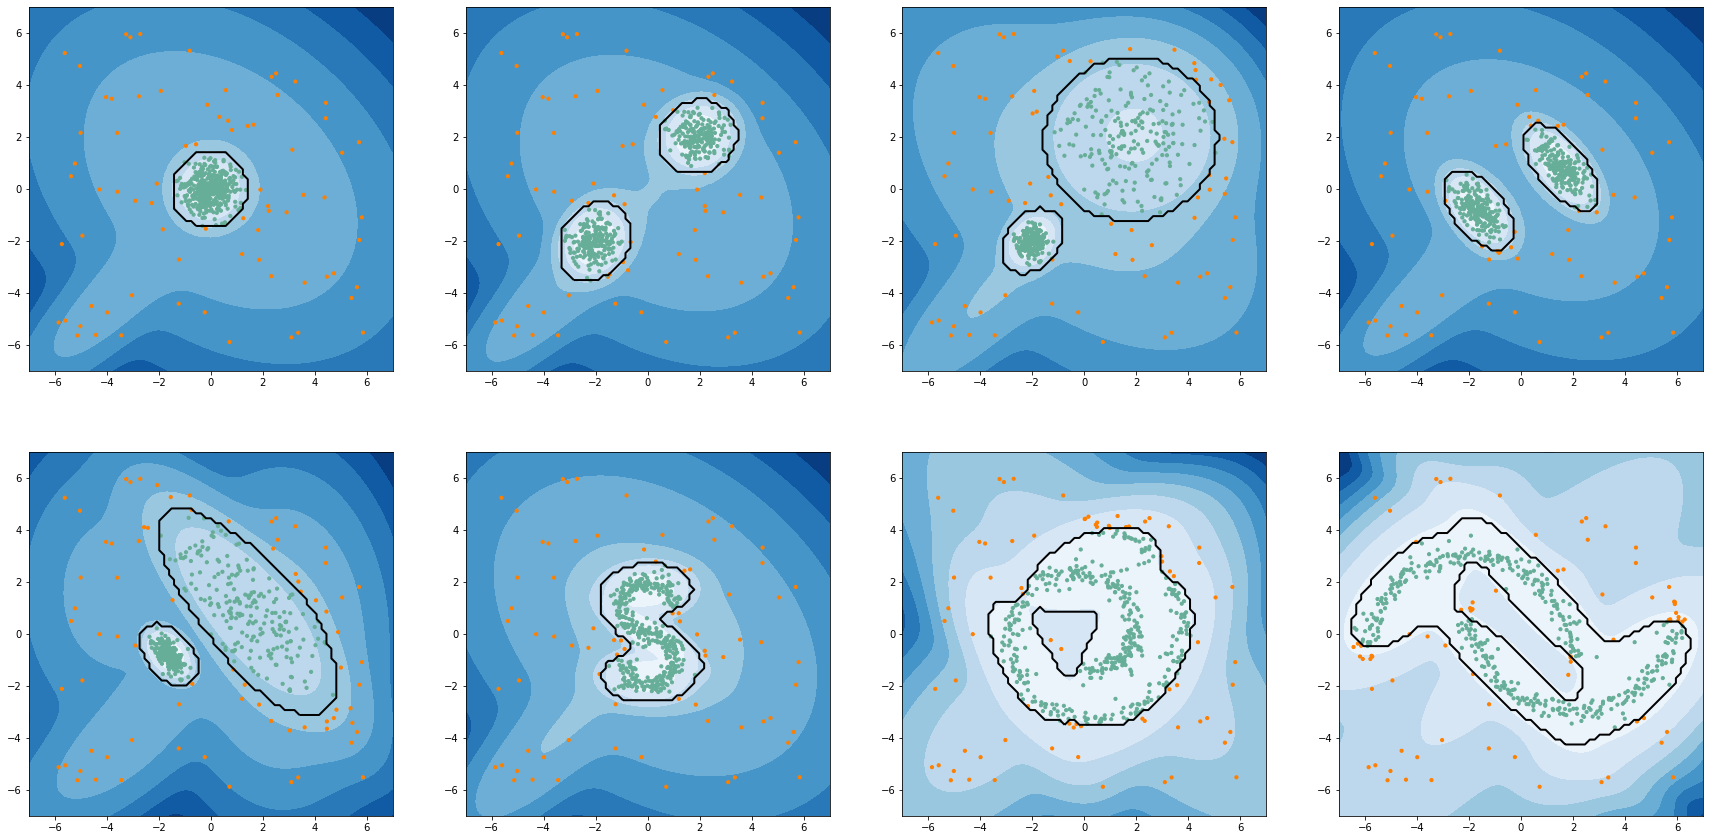

In [13]:
demo_probability_2d_data(bgmm)

### c. Kernel Density Estimation

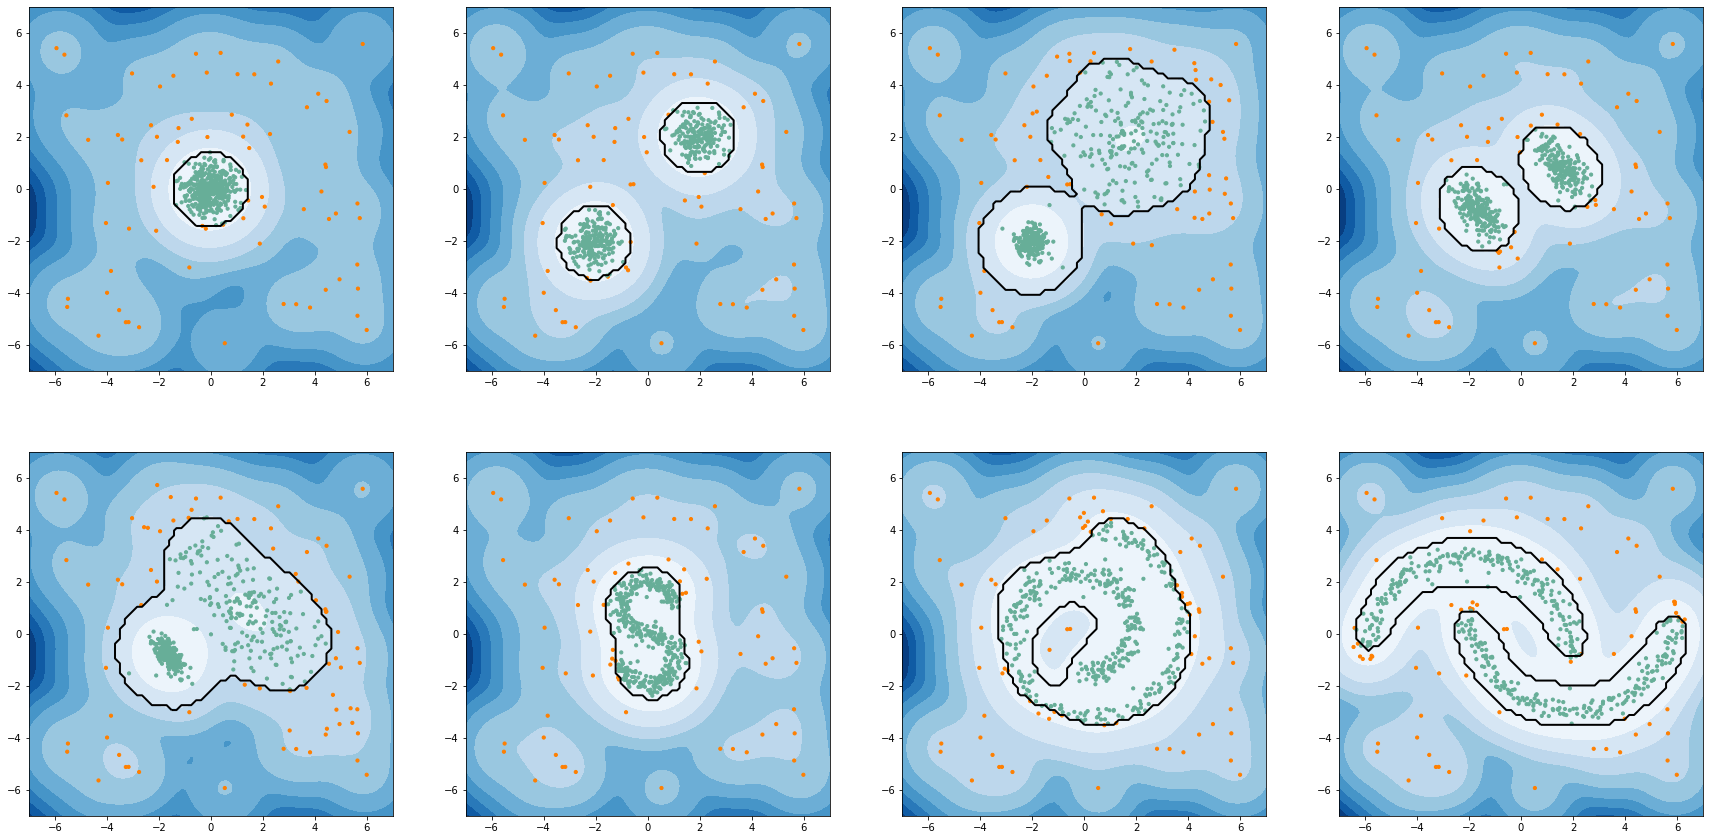

In [14]:
demo_probability_2d_data(kde)

## References